# Multilayer perceptron from scratch
Author: Kirill Shmilovich (kshmilov@gmail.com)

In this Notebook I detail how to build a multilayer perceptron for handwritten digit classification from scratch -- using only matrix multiplication libraries in Python.

# Imports

You will need [NumPy](https://www.numpy.org/) and [matplotlib](https://matplotlib.org/) if you intend to run this notebook locally.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from PIL import Image
from sklearn.model_selection import train_test_split

## Load data
One of the first steps when working with a new data set is preprocessing. However you come about your data, whether downloaded from an established dataset or created yourself, it's vital to carefully examine and prepare your data. Our data here is from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of `28x28` pixel images of handwritten digits from `0-9`, which has an important place in the history of machine learning. Some common questions to ask yourself when confronted with a new data set when preparing analysis:
1. What range of values does your data take? Do values need to be rescaled?
2. What shape is your data? Should each sample be a matrix ($n \times m$), a vector ($1 \times n$), or even a multi-dimensional tensor ($n \times m \times p \times \ldots$)?
3. Are there fringe cases that need special attention?

Our data lives in the directory `data` under the file names `mnist_train.csv` and `mnist_test.csv`, so the complete file path (from the main directory) are `data/mnist_train.csv` and `data/mnist_test.csv`. With that in mind, let's define a helper function `load_data` that we can use to quickly in our data.

In [2]:
root_dir=r"D:\IIT BHU\SEM V\IC\IC\imgs\\"
dict = {chr(i): i - ord('a') + 1 for i in range(ord('a'), ord('z') + 1)}
lis = []
for i in os.listdir(root_dir):
    path=os.path.join(root_dir,i)
    for j in os.listdir(path):
        img_path=os.path.join(path,j)
        img = Image.open(img_path).convert('L')
        l=[dict[i]]
        li=list(img.getdata())
        l=l+li
        lis+=[l]
    print(i)

a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z


In [3]:
csv_dir=r"D:\IIT BHU\SEM V\IC\IC\data\data.csv"
with open(csv_dir, 'w',newline='') as csvfile:   
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerows(lis) 

In [4]:
def load_data(dir_name):
    """
    Function for loading MNIST data stored in comma delimited files. Labels for 
    each image are the first entry in each row.

    Parameters
    ----------
    dit_name : str
         Path to where data is contained

    Returns
    -------
    X : array_like
        A (N x p=784) matrix of samples 
    Y : array_like
        A (N x 1) matrix of labels for each sample
    """
    data = list() # init a list called `data`
    
    with open(dir_name,"r") as f: # open the directory as a read ("r"), call it `f`
        for line in f: # iterate through each `line` in `f`
            split_line = np.array(line.split(',')) # split lines by `,` - cast the resultant list into an numpy array
            split_line = split_line.astype(np.float32) # make the numpy array of str into floats
            data.append(split_line) # collect the sample into the `data` list
            
    data = np.asarray(data) # convert the `data` list into a numpy array for easier indexing
    
    # as the first number in each sample is the label (0-9), extract that from the rest and return both (X,Y)
    return data[:,1:],data[:,0]

Now load the data

In [5]:
X_data,Y_data = load_data("data/data.csv")
X_train,X_test,Y_train,Y_test=train_test_split(X_data,Y_data,test_size=0.1,random_state=104)

An easy to quickly get an idea for how your data looks is to examine the shape of the matrix it's stored using the `.shape` attribute of numpy arrays. We see that the shape of `X_train` is `60000 x 784`, which tells us there are `60000` samples (images) each with dimension `784`. Each sample, typically presented as a 28 x 28 image, is unrolled into a 1-dimensional vector 28 x 28 = 784 contained within each row of `X_train`.

In [6]:
print(f"The shape of the training set is: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"The shape of the test set is: {X_test.shape[0]} x {X_test.shape[1]}")

The shape of the training set is: 6675 x 784
The shape of the test set is: 742 x 784


Now lets take a look at how the samples are represented, we can do this by calling `Y_train[index]` and `X_train[index]` (here I choose `index=0` to look at the very first sample). We first notice `Y_train[0]=5.0`, meaning this entry is the digit `5`. We will confirm this shortly by visualizing some of these samples. We then notice each entry is an integer (cast into `np.float32` in our `load_data` function) ranging from `0-255`. This representation is common when working with images. The numerical entries are interpreted as pixel intensities typically shown in gray-scale ranging between `0` (black) and `255` (white). 

In [7]:
index = 0
Y_train[index], X_train[index]

(19.0,
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          3.,  64.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,

While there is nothing in principle wrong with this `0-255` representation, the value of `255` being the maximum is specific to images and somewhat an arbitrary for our purposes. Frequently people opt to rescale their data to range between `0-1`, which will be have some nice mathematical properties for us later. Of course, this can be done by simply dividing each entry in `X_train` and `X_test` by its maximum value (accessed using `X_train.max()`). 

Further, each label in `Y_train` and `Y_test` are currently integers (e.g. `5.0` or `2.0`). For categorical data (where image is labeled between `0-9`) we opt for a one-hot encoded representation of our data. What this means is each label is converted into a binary vector (e.g. the label 2.0 would be converted to the vector `[0,0,1,0,0,0,0,0,0,0]` and the label 9.0 would be the vector `[0,0,0,0,0,0,0,0,0,1]`).

In [8]:
# rescale data between 0 - 1.0
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

# one-hot encode train (y_train) and test (y_test) set labels
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size),Y_train.astype(int)] = 1.0

y_test = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size),Y_test.astype(int)] = 1.0

Before we proceed, let's go ahead and visualize some of the inputs and their associated labels. We can do this using the `imshow` function (making sure to resize the flattened size 784 representation into a 28 x 28 matrix for compatability with `imshow`).

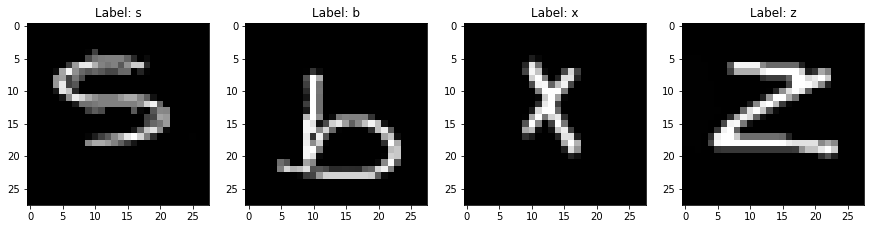

In [9]:
num_images = 4
fig,axes = plt.subplots(1,num_images,figsize=(15,10))
for image,label,ax in zip(X_train[:num_images],y_train[:num_images],axes):
    ax.imshow(image.reshape(28,28),cmap='gray',vmin=0,vmax=1.0)
    for i in range(len(label)):
        if(label[i]==1.0):
            lab=list(dict.keys())[list(dict.values()).index(i)]
    ax.set_title(f"Label: {lab}")

# Multilayer perceptron: the math 
Here some of the math underlying the multilayer perceptron (MLP) and the backpropagation algorithm are reviewed. The MLP and backpropagation are central to understanding deep learning as a whole. Full stop. What I'm presenting here is by any means *not* an exhaustive exposition of the subject, and I **highly** recommend reading (at least) [chapters 1 & 2 of the free online book: Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/) for a more complete discussion.

So what is a multilayer perceptron? Before we answer that question, let's dissect just a singular component: the perceptron. 

![Perceptron](imgs/perceptron.png)

Image credit: https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53

This image above represents schematically the conventional perceptron. Each input, represented as a multidimensional vector $\mathbf{x}=\{x_0=1,x_1,x_2,\ldots,x_n\}$, is multiplied by a set of weights $\mathbf{w} = \{w_0,w_1,w_2,\ldots,w_n\}$ to produce the weighted sum $$z = \sum_{i=0}^{n} x_i w_i$$. In the case of a vanilla perceptron, this weighted sum $z$ is lastly fed through as step function to produce the predicted output $a = \text{step}(z)$. This results in the output where $a=1$ if $z>0$ and $a=0$ if $z<0$.

With the output $a$ taking the value 0 or 1, this type of structure really only works for binary classification problems (i.e. situations where each input $\mathbf{x}$ has one of two intended labels: 0 or 1). The weights $\mathbf{w}$ in this context can be interpreted as assigning credence to the different inputs $x_i$ based on their relative importance. Notice, there is an additional constant $x_0=1$ concatenated to each input, frequently called the *bias term* or just *the bias*. As there is still an associated weight $w_0$ along with this term, this effectively acts as an offset to the origin for the classification. In other words, think of the perceptron classification boundary as a multidimensional line (or plane) $y = m * x + b$. Inputs on one side of the line where $y<0$ get classified as one label ($a=0$), while  inputs on the other side of the line where $y>0$ are classified as the other label ($a=1$). In this geometric interpretation of the perceptron, the weights are like the slope (or vector perpendicular to the plane in higher dimensions) $\mathbf{w} \sim m$, and the bias is like the $b$ term $b \sim w_0$.


Extending the perceptron to the multilayer perceptron (MLP) simply introduces a intermediate preceptrons (layers) before reading the output and generalizes the step function to a broader class of functions called *activation functions*. 

![MLP](imgs/MLP.png)

Image credit: https://github.com/PetarV-/TikZ/tree/master/Multilayer%20perceptron

These neural networks are often schematically represented with a series of nodes and arrows as shown on the right. Each node represents one input, for example the input layer here is shown with 3 inputs, and each arrow represents a *unique* weight given to that particular input in the weighted sum (right side of figure). Note, in our application to MNIST each input would be `784+1` dimensional (including the bias) and the output `10` dimensional for representing the one-hot encoded binary vector of output labels. Rather than restricting ourselves to treating each sum with a step function as in the vanilla perceptron, this concept is generalized to any arbitrary function typically called the *activation function*, depicted as $\sigma(\cdot)$ in the schematic. In principle almost any function may be an activation function, however people typically use one of the following activation functions due to some nice mathematical properties we will discuss later:

![activation_func](imgs/activation_func.png)

Image credit: https://medium.com/@shrutijadon10104776/survey-on-activation-functions-for-deep-learning-9689331ba092

The additional layers between the inputs and outputs are typically called *hidden layers* because the particular value of the nodes within these layers are typically unknown, and largely uninterpretable, to the user. A natural question to ask here is why are hidden layers helpful/necessary for deep learning? The answer is, shockingly, that they aren't necessary, but are very helpful. There exists a theorem called the "Universal Approximation Theorem" which states basically that a neural network with a single layer can approximate *any* non-linear function to arbitrary accuracy. While this may imply that only a single hidden layer is, in principle, sufficient for any problem, the necessary dimension of this hidden layer may become intractably large for some problems. Introducing many hidden layers allows your neural network to learn a hierarchy of concepts in the structure of the data. What this implies for the MLP is that earlier layers (i.e. the layers closer to the input) learn a coarser representation of the data and begins to more closely reflect the output representation nearer to the output layer. 

![deep](imgs/deep.png)

Image credit: UChicago STAT 37710 Spring 2019

### Feed forward
Given a predefined neural network *architecture* (the *architecture* of a neural network refers to all the elements necessary to completely define the flow of data, which involve the number and size of hidden layers, which activation functions, the output size, etc.) the process of generating an output from an input is called a *forward* pass. As we shall see, for an MLP the forward pass may be succinctly represented as a series of matrix multiplications.

![MLP_big](imgs/MLP_big.png)

Image credit: http://neuralnetworksanddeeplearning.com/chap1.html

Consider the MLP represented schematically above with sigmoid activations $\sigma$ in the hidden layer. Each neuron in the hidden layers will be weighted sums of the inputs: $$a_j = \sigma(\sum_{i=1}^{784} x_i* w_{i,j})$$ for $j=\{1,2,\ldots,15\}$ (notice, there is no bias term in this example). From here it clear to see that the weights $w_{i,j}$ may be compacted into a matrix $W \in {\rm I\!R}^{784\times15}$ where $W_{i,j} = w_{i,j}$, allowing for all the neurons in the hidden layer to be efficiently calculated using matrix multiplication: $\mathbf{a}^{(1)} = \sigma(\mathbf{z}^{(1)}) = \sigma(\mathbf{x}W)$. Where $\mathbf{a}^{(i)},\mathbf{z}^{(i)} \in {\rm I\!R}^{1\times 15}$, with the superscript $(i)$ indicating the assocaited layer number, and $\mathbf{x} \in {\rm I\!R}^{1\times 784}$ are both arranged as column vectors. Another, different, weight matrix is needed to transform the hidden layer to the output layer. Let's demarcate these two as $W^{(1)}$ for the matrix which transforms the inputs to the hidden layer $\mathbf{a}^{(1)}$ and $W^{(2)} \in {\rm I\!R}^{15\times 10}$ for transforming the hidden layer to the output layer $\mathbf{z}^{(2)}$. Mathematically, $$\mathbf{z}^{(2)} = \sigma(\mathbf{x}W^{(1)})W^{(2)}$$. Notice, we've yet to treat this output $\mathbf{z}^{(2)}$ with an activation function.

The last step of process for classification tasks is actually producing a prediction from these numbers in the output layer $\mathbf{z}^{(2)}$. Typically, in the case of multi-label classification, this is done using a *softmax* activation function which effectively converts the output neurons into probabilities for each label. This has the mathematical form, $$\text{softmax}(\mathbf{z})_j = \frac{\exp(z_j)}{\sum_{k=0}^{K=9}\exp{(z_k)}}$$.

The softmax activation function has the property of the outputs summing to 1 $\sum_{k=1}^{K=9}\text{softmax}(\mathbf{z}^{(2)})_k = 1$, allowing each output $\mathbf{a}^{(2)}_i = \text{softmax}(\mathbf{z}^{(2)})_i$ to be interpreted as the probability that the input is actually a digit `0-9`. Note, the output of a MLP does not need to have a softmax activation, for example in a regression setting a softmax activation would not make much sense. When evaluating the classification accuracy of the neural network, the input is typically classified according to the output label with the highest probability, $$\text{prediction}(\mathbf{x}) = \text{argmax}\  \text{softmax}(\mathbf{z}^{(2)}) = \text{argmax}\  \text{softmax}((\sigma(\mathbf{x}W^{(1)})W^{(2)}))$$.

### Backpropagation
Now that we have an understanding of how an MLP generates outputs from inputs, we engage the problem of how to actually *train* this neural network. *Training* a neural network (in a supervised setting, which means each input comes with a known output) refers to the process of iteratively updating the weights of the network to improve it's performance. The performance of the neural network is evaluated using a *loss function* which quantitatively measures how "close" the neural network output is to the true output. In short, using *backpropagation* we aim to minimize the loss function with respect to the weights (also called *parameters*) of the neural network.     

First, let's define precisely what we mean by a *cost function*. The cost function $C$ should reflect whatever objective your aim is for the neural network. Here, we're interested in having our neural network predict a digit label `0-9` for each input image. A natural, and very reasonable, choice in many settings is simply using the L2 norm between our predicted and true outputs $$C = \frac{1}{2N}\sum_{i=1}^N||y_i - \mathbf{a}^{(L)}(\mathbf{x}_i)||^2$$, where $y_i$ represents the true label corresponding to input $\mathbf{x}_i$ and $\mathbf{a}^{(L)}(\mathbf{x}_i)$ is the output of the neural network with $L$ layers taking $\mathbf{x}_i$ as input. Note, in our previous example $\mathbf{a}^{(L=2)}(\mathbf{x}_i) = \text{softmax}((\sigma(\mathbf{x}_iW^{(1)})W^{(2)}))$. Of course, when minimizing/maximizing a function any constant multiplies have no effect on the optimum which allows us to include the $\frac{1}{2N}$ as a mathematical convenience whose purpose will be clear shortly (spoiler, it has to do with derivatives). We may equivalently write this cost function in terms of the cost incurred by each sample individually as $$C = \frac{1}{N}\sum_{i=1}^N C_i$$. Where the cost of an individual training sample is of course, in the case of our quadratic cost function, $C_i = \frac{1}{2}||y_i - \mathbf{a}^{(L)}(\mathbf{x}_i)||^2$.

Ultimately, training our neural network by incrementally adjusting the weights amounts to updating each weight $W^{(l)}_{i,j}$ based on its individual influence to the cost function. This can be done with the *gradient descent* algorithm that defines the update rule $$W^{(l)}_{i,j} \leftarrow W^{(l)}_{i,j} - \alpha \frac{\partial C}{\partial W^{(l)}_{i,j}}$$, where $\alpha$ is a tunable parameter called the *learning rate*. Notice, vanilla gradient descent requires computing the derivative (people in the ML community use the word gradient, rather than derivative) $\frac{\partial C}{\partial W^{(l)}_{i,j}}$ with respect to **all** the training samples. Of course, this can become expensive very quickly as some datasets, for example, contain millions of image and it's simply intractable for computational reasons to work with all that data at once. Therefore, people typically (read, always) employ a modified version of gradient descent called *stochastic gradient descent* (SGD) which updates the weights in *batches* (also called *mini batches*) of size $m$ $$W^{(l)}_{i,j} \leftarrow W^{(l)}_{i,j} - \frac{\alpha}{m}\sum_{k \in \text{batch}} \frac{\partial C_k}{\partial W^{(l)}_{i,j}}$$. Where $C_i$ is the previously discussed cost function for an individual training sample $i$.

In order to actually perform SGD we are left with the task of evaluating the gradient $\frac{\partial C_i}{\partial W^{(l)}_{i,j}}$. However, we must be able to evaluate this gradient quickly and ideally in parallel as this calculation will be performed many, many times. This, finally, is where the *backpropagation* algorithm comes into play. 

Let's define the quantity $$\delta^{(l)}_j = \frac{\partial C}{\partial z^{(l)}_j}$$.

Recalling that each hidden layer is expressed as $a^{(l)}_i = \sigma(z^{(l)}_i) = \sigma(\sum_j W^{(l)}_{i,j} * a^{(l-1)}_j)$. Note, for simplicity I've omitted the bias term from $z$, and am using $\partial C$ rather than $\partial C_i$ for notational convenience. This $\delta^{(l)}_j$ term may be thought of as the output error for neuron $j$ in layer $l$ with respect to the cost function $C$. Using $\delta^{(l)}_j$ we can get at our sought after gradient by applying the chain rule $$\frac{\partial C_i}{\partial W^{(l)}_{i,j}} = \frac{\partial C}{\partial z^{(l)}_i} \frac{\partial z^{(l)}_i}{\partial W^{(l)}_{i,j}} = \delta^{(l)}_i * a^{(l-1)}_j$$. Where $\frac{\partial z^{(l)}_j}{\partial W^{(l)}_{i,j}} = a^{(l-1)}$ can be readily derived recalling that $z^{(l)}_i = \sum_k W^{(l)}_{i,k} * a^{(l-1)}_k$.

Excellent! Now we have a closed-form analytical expression for $\frac{\partial C_i}{\partial W_{i,j}}$. But how do we actually compute $\delta^{(l)}_j$ in this expression? Let's start with the last layer $L$ and apply the chain rule again, $$\delta^{(L)}_j = \frac{\partial C}{\partial a^{(L)}_j} \frac{\partial a^{(L)}_j}{\partial z^{(L)}_j} = \frac{\partial C}{\partial a^{(L)}_j} \sigma^{\prime}(z^{(L)}_j)$$. The first term $\frac{\partial C}{\partial a^{(L)}_j}$ is simply the error in the cost function with respect to the last layer, a quantity which can frequently be directly derived. For instance, in the case of the quadratic cost function $C = \frac{1}{2}||y - a^{(L)}_{j}||^2$, the derivative is simply $\frac{\partial C}{\partial a^{(L)}_j} = (a^{(L)}_j - y)$. Next, the $\sigma^{\prime}(z^{(L)}_j)$ is nothing more than the derivative of the activation function at numerical value of $z^{(L)}_j$. This is where the previously mentioned mathematical convenience of select activation functions comes in, say, for the sigmoid activation: $\sigma^{\prime}(x) = \sigma(x) (1-\sigma(x))$. What this means is that once we have computed $\sigma(z^{(l)}_j)$ (for any $l$) during the forward pass of the network, we can store and reuse that value to efficiently compute $\sigma^{\prime}(z^{(l)}_j)$ during backpropagation!

Okay, this is the last step. With the error in the last layer $\delta^{(L)}_j$ computed the final piece of the puzzle is computing the error for the remaining layers $\delta^{(l)}_j$. Here, I will simply state the formula for the sake of brevity -- but I encourage you to look at the proof available [here](http://neuralnetworksanddeeplearning.com/chap2.html), or even better, try to prove it yourself! 

$$\boldsymbol{\delta}^{l}=((W^{(l+1)})^{T} \boldsymbol{\delta}^{l+1}) \odot \sigma^{\prime}(\mathbf{z}^{l})$$ 

The only new notation introduced here is the *hadamard product* $\odot$: which simply performs an element-wise multiplication along two vectors (e.g. $(\mathbf{x} \odot \mathbf{y})_i = x_i * y_i$). Looking at this equation, we realize now why backpropagation is called *backpropagation*: the errors for a given layer $\boldsymbol{\delta}^{l}$ depend on the errors in the following layer $\boldsymbol{\delta}^{l+1}$. Thus, once we have computed the error in the last layer $\boldsymbol{\delta}^{L}$, backpropagation effectively works backward to compute the errors in the remaining layers which are then purposed to calcaulte the gradients $\frac{\partial C_i}{\partial W^{(l)}_{i,j}}$ used to update the weights $W^{(l)}_{i,j}$ in SGD. That's it. That's the math which drives how neural networks *actually* learn.

# Multilayer perceptron: the code
Now that we have a handle on the math behind the MLP, we can now go ahead and implement everything we've looked at in code. Of course, we want to write efficient and fast code, which when writing in Python mean using matrix (NumPy multidimensional arrays) operations whenever possible. The mindset of using NumPy arrays is generally good practice when trying to write efficient code in Python, as NumPy will automatically employ thread parallelism when performing many operations on NumPy arrays which will help substantially to accelerate our code (this is also sometimes called *vectorizing* your code).

We'll first go through and write the code for each piece of an MLP in generic Python functions. We'll then wrap everything in an `MLP` class, which will allow us to easily access all the MLP functionality in a user friendly manner.

## Feed forward

Implementing the forward pass of the neural network is relatively simply as everything is basically just a series of matrix multiplicaitons. The example we looked at when working through the math had a forward pass which mathematically took the form 
$$\text{softmax}((\sigma(\mathbf{x}W^{(1)})W^{(2)}))$$.
We'll of course want to make things a bit more modular by allowing the user to choose some of the neural network paramters, such as the number of hidden layers `N_l` and the nunber of neurons per layer `L`. For simplicity we'll restrict that all the hidden layers are treated with sigmoid activaitons and the final layer processed with a softmax activation, which if you recall will be nessesary for us to ultimately purpose this MLP to make predictions.

We can start by simply defining our activation functions:

In [10]:
def sigmoid(x):
    """
    Compute the sigmoid of `x`, calculated element-wise

    Parameters
    ----------
    x : float or array_like
        input

    Returns
    -------
    sigmoid(x) : float or array_like
        sigmoid applied to `x` element-wise
    """
    return 1./(1.+np.exp(-x))

In [11]:
def softmax(x):
    """
    Compute the softmax of `x`,

    Parameters
    ----------
    x : array_like
        (N x dim) array with N samples by p dimensions. dim=10 for MNIST classification. 

    Returns
    -------
    softmax(x) : float or array_like
        softmax applied to `x` along the first axis.
    """
    exponent = np.exp(x) # only compute the exponent once
    return exponent/exponent.sum(axis=1,keepdims=True)

The inputs `x`, weight matricies `w`, and activations are in principle all we need to define the forward pass; however, for efficency reasons we'll want to store the outputs of the hidden layer neurons when performing the forward pass. Storing these values will help us later more quickly calculate the gradients during the backward pass. The `init_layers` functions will initalize these hidden layers as NumPy arrays, doing this before we begin training will help us save some overhead we would otherwise inccur reinitalizing these hidden layers before each forward pass. These hidden layer values will be stored in multi-dimensional matricies, called *tensors*. One dimension of these tensors will be the `batch size` which will indicate the number of samples simultaneously passed to MLP during one training loop (feed forward + backpropagation).

In [12]:
def init_layers(batch_size,layer_sizes):
        """
        Initalize arrays to store the hidden layer ouputs.

        Parameters
        ----------
        batch_size : int
            Number of samples to concurrently feed through the network.
        layer_sizes : array_like
            Array of length `N_l`. Each entry is the number of neurons in each layer.

        Returns
        -------
        hidden_layers : list
            List of empty arrays used to hold hidden layer outputs. 
        """ 
        hidden_layers = [np.empty((batch_size,layer_size)) for layer_size in layer_sizes]
        return hidden_layers

In order to perform a forward pass our input `x` is consequtively multiplied by weight matricies passed into the associated activaiton functions. The paramters in these weight matricies will ultimately be learned through backpropagation, but each weight matrix must first be initalized to random values. There are a number of different methods for doing this initalization, but for the moment we'll use a simple approach of just drawing the numerical values from a normal distribution with mean zero and standard deviation 1. We could have also reasonably choosen to simply draw from a uniform distribution on the range `[-1,1]` (why would it be wrong to initalize the weight matricies with all zeros?). 

In [13]:
def init_weights(layer_sizes):
        """
        Initalize the paramters of the weight matricies.

        Parameters
        ----------
        layer_sizes : array_like
            Array of length `N_l`. Each entry is the number of neurons in each layer.

        Returns
        -------
        weights : array_like
            Randomly initalized weight matricies based on the layer sizes. 
        """
        weights = list()
        for i in range(layer_sizes.shape[0]-1):
            weights.append(np.random.uniform(-1,1,size=[layer_sizes[i],layer_sizes[i+1]]))
        weights = asarray(self.weights)
        return weights

Finally, we define the `feed_forward` function to iterate though the calculations to perform the forward pass.

In [14]:
def feed_forward(batch,hidden_layers,weights):
    """
    Perform a forward pass of the neural network.

    Parameters
    ----------
    batch : array_like
        (batch_size x dim) matrix of inputs
    hidden_layers : list
        List of hidden layer outputs
    weights : array_like
        Array of weight matricies
    
    Returns
    -------
    output : array_like
        Forward pass output of the MLP
    hidden_layers : array_like
        List of hidden layer outputs, populated from the forward pass.
    """
    h_l = batch
    hidden_layers[0] = h_l
    for i,weight in enumerate(weights):
        h_l = sigmoid(h_l.dot(weight))
        hidden_layers[i+1]=h_l
    output = softmax(hidden_layers[-1])
    return output, hidden_layers

## Backpropagation

Initalizing all the weights, layers, and activations prior to the forward pass makes much of the backward pass implimentation actually quite simple. For convinience we'll define a `sigmoid_prime` function, which simply computes the derivative of the sigmoid activation $\sigma^{\prime}$. We'll use this when computing the gradients during the backward pass. Recall, $\sigma^{\prime}(x) = \sigma(x)(1-\sigma(x))$.

In [15]:
def sigmoid_prime(sigmoid_out):
    """
    Calculate derivative of sigmoid activation based on sigmoid output.

    Parameters
    ----------
    sigmoid_out : array_like
        Output values processed by a sigmoid function.
    
    Returns
    -------
    sigmoid_prime(h) : array_like
        Derivative of sigmoid, based on value of sigmoid.
    """
    return h*(1-h)

With everything else in place computing we're finally ready to write the backpropagation algorithm. Again, the primary goal of this step is to update the parameters of the weight matricies using stochastic gradient descent on batches of training samples, measuring the error by comparing the outputs of neural network with the true labels. 

In [16]:
def back_prop(output,batch_y,hidden_layers,weights,batch_size,lr):
        """
        Calculate derivative of sigmoid activation based on sigmoid output.

        Parameters
        ----------
        output : array_like
            Forward pass output of the MLP
        batch_y : array_like
            True labels for the samples in the batch
        hidden_layers : list
            List of hidden layer outputs  
        weights : array_like
            Array of weight matricies
        lr : float
            Learning rate for SGD
        batch_size : int
            Size of a training mini-batch

        Returns
        -------
        weights : array_like
            Array of weight matricies, updated from the backpropagation.
    
        """
        delta_t = (output - batch_y)*sigmoid_prime(hidden_layers[-1])
        for i in range(1,len(weights)+1):
            weights[-i]-=lr*(hidden_layers[-i-1].T.dot(delta_t))/batch_size
            delta_t = sigmoid_prime(hidden_layers[-i-1])*(delta_t.dot(weights[-i].T))
        return weights

## Training

Having defined all the functions required to actually train the neural network, we're finally ready to assimilate everything into a training loop. The number of `epochs` we set defines the number of iterations we train our model. In each `epoch` a number of forward + backward pass are iteratively performed on mini-batches of data until our neural network has *seen* all the training data.

A number of new functions such as `loss`, `accuracy`, and `to_categorical` are used in the `train` function below. These are used to record some metrics we'll display during learning and will be defined in full in our final implimentation.

In [17]:
def train(X,Y,layer_sizes,batch_size=8,epochs=25,lr=1.0):
    """
    Train the MLP.

    Parameters
    ----------
    X : array_like
        Forward pass output of the MLP
    Y : array_like
        True labels for the samples in the batch
    layer_sizes : 
        Array of length `N_l`. Each entry is the number of neurons in each layer
    batch_size : int
        Size of a training mini-batch
    epochs : int
        Number of iterations to train for
    lr : float
        Learning rate for SGD

    Returns
    -------
    weights : array_like
        Array of weight matricies, updated from the backpropagation.

    """
    n_samples = X.shape[0]
    
    hidden_layers = init_layers(batch_size,layer_sizes)
    weights = init_weights(layer_sizes)
    for epoch in range(epochs):
        start = time.time()
        
        shuffle = np.random.permutation(n_samples)       
        X_batches = np.array_split(X[shuffle],n_samples/batch_size)
        Y_batches = np.array_split(Y[shuffle],n_samples/batch_size)
        
        train_loss = 0
        train_acc = 0
        
        for batch_x,batch_y in zip(X_batches,Y_batches):
            output,hidden_layers = feed_forward(batch_x,hidden_layers,weights)  
            train_loss += loss(output,batch_y)
            train_acc += accuracy(to_categorical(output),batch_y)
            weights = back_prop(output,batch_y,hidden_layers,weights,batch_size,lr)

        train_loss = (train_loss/len(X_batches))
        train_acc = (train_acc/len(X_batches))

        train_time = round(time.time()-start,3)

        print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")
    
    return weights

# Multilayer Perceptron: final form
Everything that's been outlined suffices for running the MLP. However, as it stands things are still quite clunkly. We can clean everything up by wrapping all this code into a Python Class. If you're unfamiliar with object oriented programming in Python, I highly reccomend checking out this tutorial. 

Our original function defintions have been slightly changed to help absuse some of the properties of having a class structure. A number of new functions, such as `predict` and `evaluate`, have been defined in the `MLP` class. Carefully go through this code and try to understand exactly what's being done and why.

In [18]:
class MLP():
    
    def __init__(self,X,Y,X_val,Y_val,L=1,N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(27)[Y.astype(int).reshape(-1)])
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        self.Y_val = np.squeeze(np.eye(27)[Y_val.astype(int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes =np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc,self.train_time,self.tot_time]
        
    def __sigmoid(self,x):
        # VCompute the sigmoid
        return 1./(1.+np.exp(-x))
    
    def __tanh(self,x):
        return np.tanh(x)
    
    # def __relu(self,x):
    #     return np.maximum(x,0)
    
    def __softmax(self,x):
        # Compute softmax along the rows of the input
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)
    
    def __loss(self,y_pred,y):
        # Compute the loss along the rows, averaging along the number of samples
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self,y_pred,y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.all(y_pred==y,axis=1).mean()
    
    def __sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    def __tanh_prime(self,h):
        return 1-h**2
    
    # def __relu_prime(self,h):
    #     return (h>0).astype(h.dtype)
    
    def __to_categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = list()
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
        self.weights = np.asarray(self.weights)
    
    def __init_layers(self,batch_size):
        # Initialize and allocate arrays for the hidden layer activations 
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self,batch):
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__tanh(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self,batch_y):
        # Update the weights of the network through back-propagation
        delta_t = (self.__out - batch_y)*self.__tanh_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.___prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self,X):
        # Generate a categorical, one-hot, prediction given an input X
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    
    def evaluate(self,X,Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction = self.predict(X)
        return self.__accuracy(prediction,Y)
        
    def train(self,batch_size=8,epochs=25,lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")
    

Great, now let's give this a try. Let's create a really simple MLP with only a single hidden layer `L=1` with 128 neurons `N_l=128`. We'll train with a `batch_size=8` for `epochs=25` and a learning rate `lr=1.0`.

In [19]:
model = MLP(X_train,Y_train,X_test,Y_test,L=1,N_l=256)
model.train(batch_size=8,epochs=40,lr=0.07)

C:\Users\Soustab\AppData\Local\Temp\ipykernel_38136\861714966.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.weights = np.asarray(self.weights)


AttributeError: 'MLP' object has no attribute '_MLP___prime'

Note, along with the training data, `X_train` and `Y_train`, we include a validation dataset, `X_val` and `Y_val`. The purpose of this data is to evaluate the generizability of our model. We expect our model to perform well on our training data, because of course the objective of our optimization is to minimize the error with respect to the training data, but we'd like our model to generalize to new, never before seen, data. We therefore evaluate the accuracy and loss on a hold-out set which the model never sees during training. If the performance is good on this hold-out set we can be confident that our model is generalizing well, meaning we've mananged to generally teach a computer to read hand-writing. 

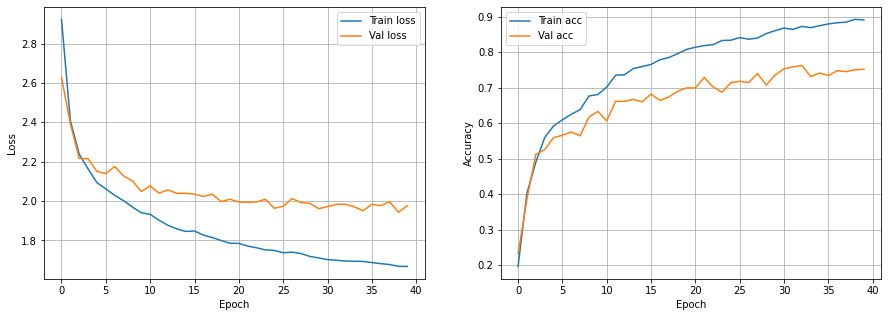

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

Although the results here are impressive, the *hyperparamters* were carefully currated to achieve this good performance. The *hyperparamters* reffer to the paramters of the model which are not learned during the training loop (e.g. the `batch_size`, learning rate `lr`, number of hidden layers `N_l`, number of neurons-per-layer `L`). In general, these paramters need to be carefully tuned depending on the details and idiosycrisies of each problem. This tuning process tpyically involves training a model to completion under a number of different hyperparamter settings and selecting the combination of hyperparamters which yields the highest performance (measured in this case by the accuracy on our training set).

In [ ]:
model.evaluate(X_test,y_test)

0.7520215633423181

In [ ]:
model2 =  MLP(X_train,Y_train,X_test,Y_test,L=1,N_l=256)
model2.train(batch_size=8,epochs=40,lr=0.10)

C:\Users\Soustab\AppData\Local\Temp\ipykernel_33336\1360422828.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.Y = np.squeeze(np.eye(27)[Y.astype(np.int).reshape(-1)])
C:\Users\Soustab\AppData\Local\Temp\ipykernel_33336\1360422828.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curre

Epoch 1: loss = 3.596 | acc = 0.001 | val_loss = 3.296 | val_acc = 0.0 | train_time = 1.594 | tot_time = 1.598
Epoch 2: loss = 3.295 | acc = 0.0 | val_loss = 3.296 | val_acc = 0.0 | train_time = 1.391 | tot_time = 1.396
Epoch 3: loss = 3.295 | acc = 0.0 | val_loss = 3.296 | val_acc = 0.0 | train_time = 1.289 | tot_time = 1.293
Epoch 4: loss = 3.295 | acc = 0.0 | val_loss = 3.296 | val_acc = 0.0 | train_time = 1.357 | tot_time = 1.361
Epoch 5: loss = 3.295 | acc = 0.0 | val_loss = 3.296 | val_acc = 0.0 | train_time = 1.423 | tot_time = 1.427
Epoch 6: loss = 3.295 | acc = 0.0 | val_loss = 3.296 | val_acc = 0.0 | train_time = 1.429 | tot_time = 1.433


KeyboardInterrupt: 